In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
class Node:
    def __init__(self, value: np.ndarray, parent: "Node | None"):
        """
        value: length N array of ints
        """

        self.value = value
        self.parent = parent

    def get_human_readable_value(self):
        # fmt: off
        value_to_base = [
            "AA", "CC", "GG", "TT",
            "AC", "AG", "AT", "CG",
            "CT", "GT", "CA", "GA",
            "TA", "GC", "TC", "TG",
        ]
        # fmt: on
        return "|".join([value_to_base[v] for v in self.value])

    def get_phy_value(self, human_readable=False):
        # fmt: off
        value_to_base = [
            "A", "C", "G", "T",
            # represent as unphased
            "M", "R", "W", "S", "Y", "K",
            "M", "R", "W", "S", "Y", "K",
        ]
        # fmt: on

        return "".join([value_to_base[v] for v in self.value])


class Simulate_GT16:
    pool_size = 20
    final_leaf_count = 20
    child_sample_count = 10
    dt = 1
    sim_steps = 10

    def __init__(self, exchangeability: np.ndarray, stationary: np.ndarray, N: int):
        """
        exchangeability: length 6
        stationary: length 16
        N: number of sites
        """

        self.pi = exchangeability
        self.stat = stationary
        self.N = N
        self.A = 16

        self.Q = self.get_Q()
        self.plot_Q()

        self.healthy_cell, self.leaf_cells = self.simulate()

    def get_Q(self):
        pi8 = np.repeat(self.pi, 8)

        # index helpers for Q matrix
        AA, CC, GG, TT, AC, AG, AT, CG, CT, GT, CA, GA, TA, GC, TC, TG = range(self.A)

        # fmt: off
        updates = [
          # | first base changes                    | second base changes
            [AA, CA], [AC, CC], [AG, CG], [AT, CT], [AA, AC], [CA, CC], [GA, GC], [TA, TC], # A->C
            [AA, GA], [AC, GC], [AG, GG], [AT, GT], [AA, AG], [CA, CG], [GA, GG], [TA, TG], # A->G
            [AA, TA], [AC, TC], [AG, TG], [AT, TT], [AA, AT], [CA, CT], [GA, GT], [TA, TT], # A->T
            [CA, GA], [CC, GC], [CG, GG], [CT, GT], [AC, AG], [CC, CG], [GC, GG], [TC, TG], # C->G
            [CA, TA], [CC, TC], [CG, TG], [CT, TT], [AC, AT], [CC, CT], [GC, GT], [TC, TT], # C->T
            [GA, TA], [GC, TC], [GG, TG], [GT, TT], [AG, AT], [CG, CT], [GG, GT], [TG, TT], # G->T
        ]
        # fmt: on

        R = np.zeros((self.A, self.A))

        for update, pi_val in zip(updates, pi8):
            R[update[0], update[1]] = pi_val

        R = R + R.T

        y_q = R @ np.diag(self.stat)
        hyphens = np.sum(y_q, axis=1)
        Q = np.copy(y_q)
        np.fill_diagonal(Q, -hyphens)
        return Q

    def plot_Q(self):
        plt.title("Q matrix used for simulation")
        plt.imshow(self.Q)
        plt.show()

    def sample(self, probabilities: np.ndarray):
        """
        probabilities: length A
        """

        normalized_probabilities = probabilities / np.sum(probabilities)
        return np.random.choice(self.A, p=normalized_probabilities)

    def probabilities_to_cell(self, probabilities: np.ndarray, parent: Node | None):
        """
        probabilities: N x A
        """

        sampled_value = np.apply_along_axis(self.sample, 1, probabilities)
        return Node(sampled_value, parent)

    def evolve_cell(self, cell: Node):
        # expand length N array cell.value into N x A array of one-hot vectors
        value_one_hot = np.eye(self.A)[cell.value]

        probabilities = scipy.linalg.expm(self.Q * self.dt) @ value_one_hot.T  # A x N
        probabilities = probabilities.T  # N x A
        return self.probabilities_to_cell(probabilities, cell)

    def simulate(self) -> tuple[Node, list[Node]]:
        probabilities_across_sites = np.tile(self.stat, (self.N, 1))
        pool = [
            self.probabilities_to_cell(probabilities_across_sites, None)
            for _ in range(self.pool_size)
        ]

        healthy_cell = pool[0]

        for _ in tqdm(range(self.sim_steps)):
            new_pool = []

            for cell in pool:
                for _ in range(self.child_sample_count):
                    new_pool.append(self.evolve_cell(cell))

            pool = np.random.choice(new_pool, size=self.pool_size, replace=False)

        leaf_cells = np.random.choice(pool, size=self.final_leaf_count, replace=False)  # type: ignore
        return healthy_cell, list(leaf_cells)

    def save_to_dot_phy(self, path: str):
        total_cells = self.final_leaf_count + 1  # including healthy cell

        with open(path, "w") as f:
            f.write(f"{total_cells} {self.N}\n")
            f.write(f"Healthy    {self.healthy_cell.get_phy_value()}\n")

            for i, cell in enumerate(self.leaf_cells):
                f.write(f"CELL-{i}    {cell.get_phy_value()}\n")

exchangeability: [0.01536991 0.02873285 0.01301024 0.01083768 0.01598181 0.02011033]
stationary: [4.89785269e-01 7.18546898e-01 5.72905748e-01 1.55307042e-01
 7.37513326e-01 6.36765894e-01 9.92974942e-01 6.24156411e-01
 5.62005437e-04 2.43542504e-03 5.20658353e-01 8.95980001e-01
 5.52582152e-01 2.08037120e-01 1.40883927e-01 5.74881450e-01]


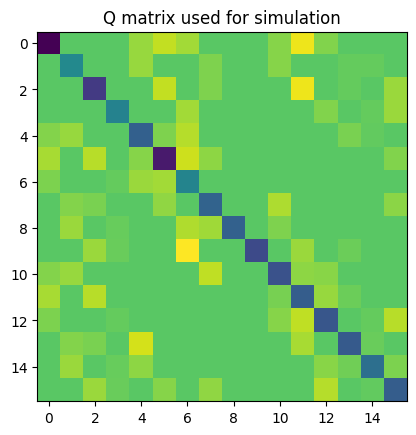

100%|██████████| 10/10 [00:15<00:00,  1.56s/it]

Saved to ./data/cellphy_simulated_set.phy
AT|AA|GA|CC|AG|TC|GA|CC|CA|AA|TG|CA|GA|TT|AA|TG|AC|AT|AT|AT|AA|CA|AG|AC|AC|AC|AC|AG|AC|TA|GC|CG|TG|AC|TA|AG|CA|TA|AT|AA|GA|AG|AC|CC|AA|CG|GG|CA|AT|GA|GG|TG|AT|GA|GC|GG|TA|AG|GA|TA|CC|GG|TT|GA|AG|AA|CA|AT|AT|AG|CA|GA|CA|GG|AA|AG|GG|GA|CA|AG|CA|AC|AG|CA|AC|AT|GG|AC|TA|AA|CA|CC|CG|CA|GA|AC|TC|GA|CC|TG|TA|AA|TA|TG|TT|TA|CA|AT|CG|AT|AC|GG|GA|GG|AC|TA|AC|CC|CA|AA|AC|CG|AG|TA|TC|GG|CG|TA|AA|AT|AT|GA|GA|TG|AG|AC|TA|CA|GA|AA|CG|AT|TG|GG|CC|AA|AC|CG|AA|GC|TG|CC|AG|GA|AT|AT|TT|TT|CG|TA|GG|AT|AG|TA|AG|AT|TA|GA|GA|AC|CA|TG|TA|GA|CA|AT|CG|CA|AT|AT|AT|AA|AT|TC|AG|TG|CG|AG|AT|AG|AA|CC|TG|AA|GA|TG|AC|CG|GA|CC|TG|GG|CC|AT|GA|TA|AG|AC|GA|AT|CC|TA|AT|CG|AT|GG|GG|AT|AT|TG|AC|AC|AG|GA|CG|AA|AT|AC|GG|AT|AC|GG|CG|CG|GC|CG|TA|TA|CG|TA|CA|GA|CA|CC|GA|AT|AC|GA|CG|TC|GA|TG|CA|AT|CG|AA|CA|TA|CA|AG|CG|CC|GA|CG|AT|AT|GG|CC|AT|TT|GG|CG|GA|GA|AG|AA|GA|GA|TT|GA|CG|CC|AG|AT|CC|AT|GG|CA|CG|TT|GA|AA|GG|CA|AG|TG|TG|TA|TA|TG|AT|AG|TG|GA|GC|GG|CC|AA|CG|AT|AC|TG|CC|AA|AT|AT|AG|GA|CC|C

In [4]:
exchangeability = np.random.uniform(0, 0.03, 6)
stationary = np.random.uniform(0, 1, 16)
N = 500

print(f"exchangeability: {exchangeability}")
print(f"stationary: {stationary}")

dot_phy_path = "./data/cellphy_simulated_set.phy"

simulation = Simulate_GT16(exchangeability, stationary, N)

simulation.save_to_dot_phy(dot_phy_path)
print(f"Saved to {dot_phy_path}")

for cell in [simulation.healthy_cell] + simulation.leaf_cells:
    print(cell.get_human_readable_value())